In [1]:
from clique_benchmark import Trials
from graph_database import Graphs, Graph
import matplotlib.pyplot as plt
import numpy as np
graph_db = Graphs()
trial_db = Trials()

In [2]:
# run this cell to load the job results for all trials that are waiting pending job results
await trial_db.load_results()

In [3]:
for grover_iterations in range(1, 6):
    print(f"Grover iterations: {grover_iterations}")
    for trial in trial_db.get(grover_iterations=grover_iterations):
        print(f"Trial {trial.trial_id} with graph: {trial.graph}")
        print(sorted(trial.counts.items(), key=lambda t: t[1], reverse=True))
        print(sorted(trial.simulation_counts.items(), key=lambda t: t[1], reverse=True))
        print(trial.success_rate)
        print(trial.simulation_success_rate)
        print(trial.expected_success_rate)
        print("")

Grover iterations: 1
Trial 1 with graph: 001
[('000', 247), ('010', 206), ('011', 142), ('111', 111), ('100', 81), ('110', 76), ('001', 74), ('101', 63)]
[('110', 450), ('000', 104), ('111', 79), ('001', 77), ('101', 75), ('010', 73), ('011', 72), ('100', 70)]
0.076
0.45
0.7812500000000001

Trial 3 with graph: 100
[('011', 164), ('001', 153), ('101', 152), ('111', 145), ('010', 127), ('000', 91), ('110', 86), ('100', 82)]
[('011', 480), ('000', 90), ('110', 87), ('100', 79), ('101', 76), ('001', 65), ('111', 64), ('010', 59)]
0.164
0.48
0.7812500000000001

Trial 5 with graph: 010
[('011', 276), ('010', 170), ('001', 159), ('000', 118), ('110', 107), ('100', 82), ('111', 51), ('101', 37)]
[('101', 475), ('010', 85), ('011', 84), ('001', 76), ('100', 74), ('111', 70), ('000', 70), ('110', 66)]
0.037
0.475
0.7812500000000001

Trial 7 with graph: 011
[('101', 362), ('110', 202), ('100', 129), ('111', 81), ('001', 81), ('000', 52), ('011', 47), ('010', 46)]
[('101', 520), ('110', 480)]
0.56

In [4]:
def get_probability_data(trial_db):
    n_data = []
    grover_iterations_data = []
    probability_data = []

    for n in range(2, 21):
        for grover_iterations in range(1, 6):
            print(f"(n, grover_iterations) = ({n}, {grover_iterations})")
            trials = trial_db.get(n=n, grover_iterations=grover_iterations)

            if len(trials) == 0:
                print(f"Warning: no results for {n} variables, complexity {grover_iterations}; skipping")
                continue

            success_rates = np.zeros(len(trials))
            expected_success_rates = np.zeros(len(trials))

            for i, trial in enumerate(trials):
                success_rates[i] = trial.success_rate
                expected_success_rates[i] = trial.expected_success_rate
            
            n_data.append(n)
            grover_iterations_data.append(grover_iterations)
            probability_data.append(np.mean(success_rates / expected_success_rates))
            print(f"Mean success rate over expected: {probability_data[-1]}")
    
    return n_data, grover_iterations_data, probability_data

def plot_probability_data(n_data, grover_iterations_data, probability_data, title, filepath=None):
    plt.figure(figsize=(20, 10))
    plt.scatter(n_data, grover_iterations_data, c=probability_data, cmap='RdYlGn', edgecolors='black', alpha=0.75, s=450)
    plt.xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    plt.yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))

    plt.xlabel('Verticies Count')
    plt.ylabel('Grover Iterations')
    plt.title(title)
    cbar = plt.colorbar()
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
n_data, grover_iterations_data, probability_data = get_probability_data(trial_db)

(n, grover_iterations) = (2, 1)
(n, grover_iterations) = (2, 2)
(n, grover_iterations) = (2, 3)
(n, grover_iterations) = (2, 4)
(n, grover_iterations) = (2, 5)
(n, grover_iterations) = (3, 1)
Mean success rate over expected: 0.34075999999999995
(n, grover_iterations) = (3, 2)
Mean success rate over expected: 0.15585674931129478
(n, grover_iterations) = (3, 3)
(n, grover_iterations) = (3, 4)
(n, grover_iterations) = (3, 5)
(n, grover_iterations) = (4, 1)
Mean success rate over expected: 0.2593168666832038
(n, grover_iterations) = (4, 2)
Mean success rate over expected: 0.11140934405394107
(n, grover_iterations) = (4, 3)
Mean success rate over expected: 0.05981365375152775
(n, grover_iterations) = (4, 4)
(n, grover_iterations) = (4, 5)
(n, grover_iterations) = (5, 1)
(n, grover_iterations) = (5, 2)
(n, grover_iterations) = (5, 3)
(n, grover_iterations) = (5, 4)
(n, grover_iterations) = (5, 5)
(n, grover_iterations) = (6, 1)
Mean success rate over expected: 0.11647000738454047
(n, grover_

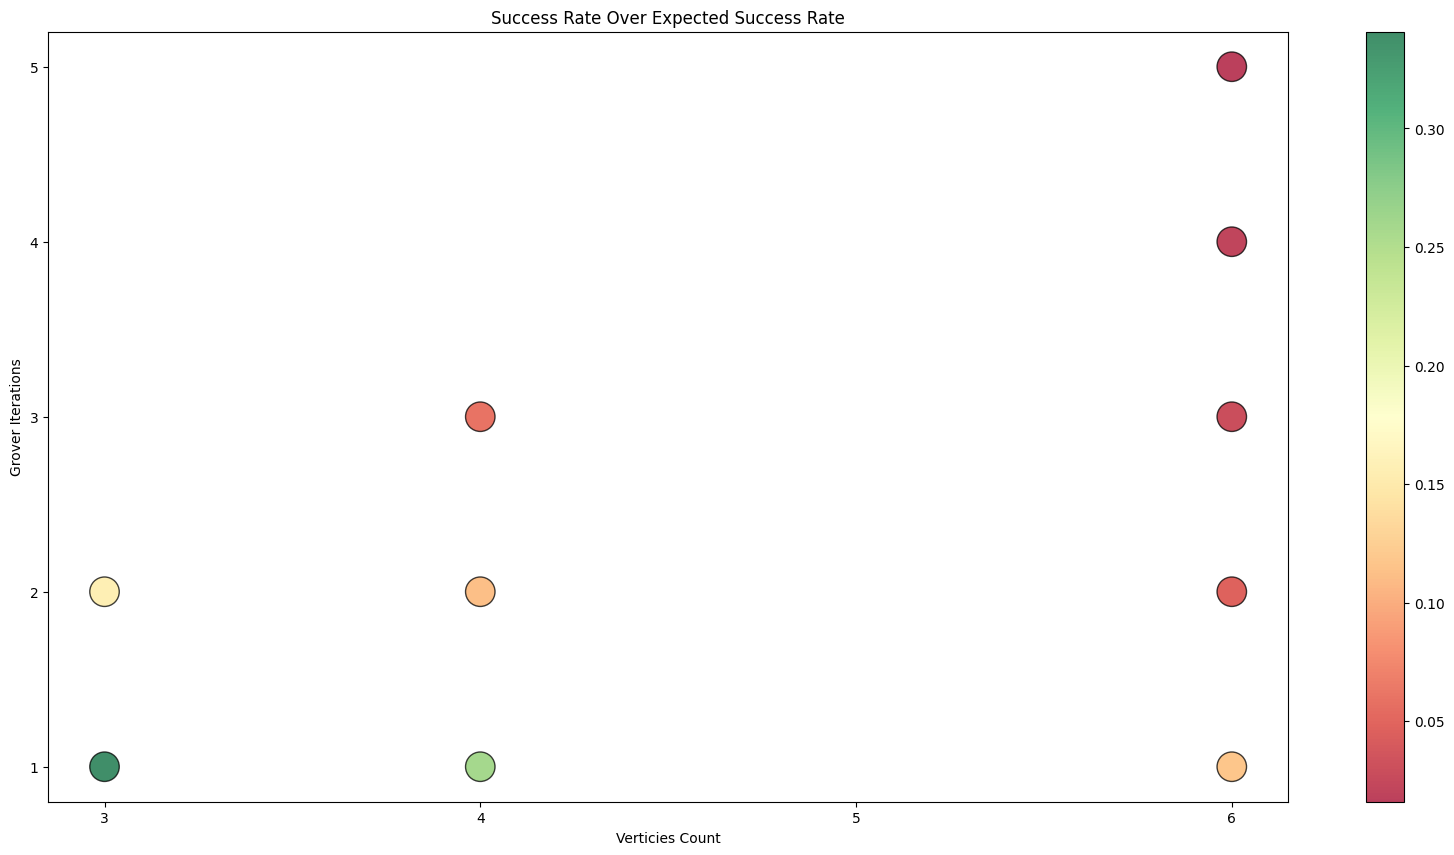

In [6]:
plot_probability_data(n_data, grover_iterations_data, probability_data, "Success Rate Over Expected Success Rate", filepath="mean_success_rate_over_expected.png")